In [43]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout

In [44]:
#exchange_data = pd.read_csv('USD_VND Historical Data.csv')
#exchange_data = pd.read_csv('USD_EUR Historical Data.csv')
exchange_data = pd.read_csv('USD_RUB Historical Data.csv')
exchange_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/29/2023,90.36,89.36,90.5701,88.8773,NaN,1.12%
1,12/28/2023,89.36,91.27,91.2700,89.2805,NaN,-2.09%
2,12/27/2023,91.27,91.66,91.9793,91.2369,NaN,-0.43%
3,12/26/2023,91.66,91.75,91.9388,91.3750,NaN,-0.10%
4,12/25/2023,91.75,92.00,92.1875,91.6576,NaN,-0.27%


In [45]:
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)

In [46]:
#checking first few records of the dataset
ind_exchange_data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-12-29,90.36,89.36,90.5701,88.8773,NaN,1.12%
2023-12-28,89.36,91.27,91.2700,89.2805,NaN,-2.09%
2023-12-27,91.27,91.66,91.9793,91.2369,NaN,-0.43%
2023-12-26,91.66,91.75,91.9388,91.3750,NaN,-0.10%
2023-12-25,91.75,92.00,92.1875,91.6576,NaN,-0.27%


In [47]:
# sorting the dataset in ascending order of date
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame.head()

,Change %,High,Low,Open,Price,Vol.
Date,,,,,,
2010-01-01,0.00%,30.3135,30.1000,30.1000,30.1000,NaN
2010-01-04,0.72%,30.5450,30.1000,30.1000,30.3175,NaN
2010-01-05,-0.72%,30.3175,29.9060,30.3175,30.1000,NaN
2010-01-06,0.00%,30.1000,29.8565,30.1000,30.1000,NaN
2010-01-07,0.00%,30.1000,29.8250,30.1000,30.1000,NaN


<Axes: xlabel='Date'>

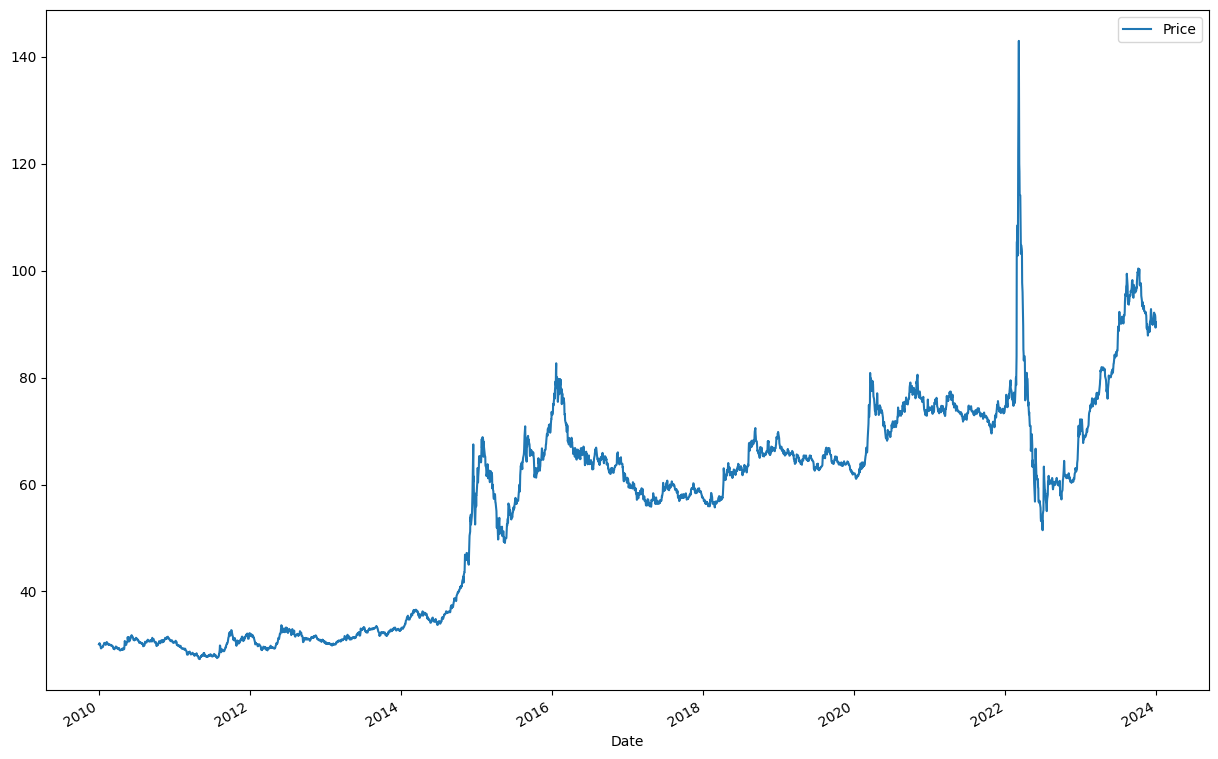

In [48]:
df = data_frame[["Price"]]
#visualize the pattern of prices over the years
df.plot(kind='line',figsize=(15,10))

 dataset in terms of years and further check 100% of the dataset lies within which interval

In [49]:
diff = df.index.values[-1] - df.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("100 percent data = 2010 to %d"%(2010 + int(1*years)))

Total data: 14 years
100 percent data = 2010 to 2024


In [50]:
# Summary Statistics
df.describe()

,Price
count,3593.000000
mean,55.239082
std,19.392387
min,27.341500
25%,32.377000
50%,60.600000
75%,68.657700
max,143.000000


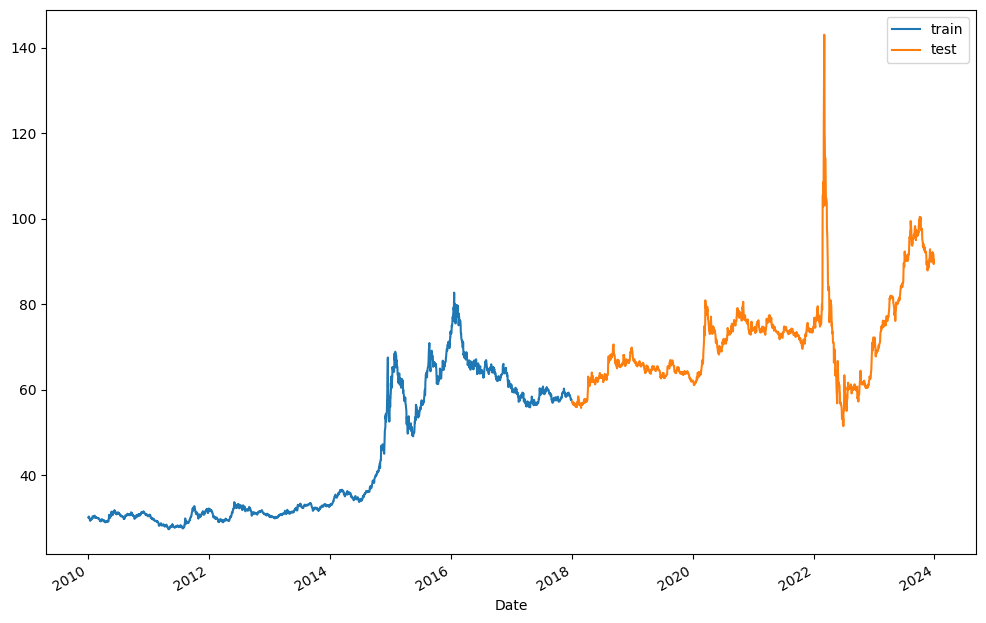

In [51]:
# Train Test Split
split_date = pd.Timestamp('01-01-2018')

train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(kind='line',figsize=(12,8))
test.plot(ax=ax,kind='line',figsize=(12,8))
plt.legend(['train', 'test'])

### Data Normalization

In [52]:
from sklearn.preprocessing import StandardScaler

In [53]:
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [54]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [55]:
X_train

array([[-0.86585799],
       [-0.85165347],
       [-0.86585799],
       ...,
       [ 0.93161693],
       [ 0.93941472],
       [ 0.92458325]])

### Data preprocessing for LSTM

In [56]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

### LSTM

In [57]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.summary()

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
model_lstm.compile(loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=100, batch_size=32, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4858 - rmse: 0.6751
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2092 - rmse: 0.4126
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0958 - rmse: 0.2325
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0486 - rmse: 0.1458   
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0230 - rmse: 0.1004   
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0119 - rmse: 0.0728    
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0084 - rmse: 0.0627    
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072 - rmse: 0.0589    
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064 - rmse: 0.0560    
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0057 - rmse: 0.0533    
Epoch 11/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - rmse: 0.0508    
Epoch 12/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0046 - rmse: 0.

In [59]:
#model_lstm.save('lstm.h5')
#print("Saving the model as lstm.h5")

#model_lstm.save('lstm_EUR.h5')
#print("Saving the model as lstm_EUR.h5")

model_lstm.save('lstm_RUB.h5')
print("Saving the model as lstm_RUB.h5")

Saving the model as lstm_RUB.h5


### LSTM Prediction

In [60]:
import os

# Get the current working directory
cwd = os.getcwd()

# Construct the full path to the model file
model_file_path = os.path.join(cwd, 'lstm.h5')

# Check if the model file exists
if os.path.exists(model_file_path):
    print(f"The model file 'lstm.h5' is saved at: {model_file_path}")
else:
    print("The model file 'lstm.h5' is not found in the current working directory.")


The model file 'lstm.h5' is saved at: c:\Users\Administrator\Desktop\DACNTT\CD.34_TrinhHungCuong_520h0286_520h0484\source\lstm.h5


In [61]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)

train_mse = metrics.mean_squared_error(y_train, y_train_pred_lstm)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test_lstm)
rmse_test = np.sqrt(test_mse)
def adj_r2_score(r2, n, k):
  return 1-((1-r2)*((n-1)/(n-k-1)))

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred_lstm)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test_lstm)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
The R2 score on the Train set is:	0.999
The  MAE on the Train set is:	0.022
The  RMSE on the Train set is:	0.038
The Adjusted R2 score on the Train set is:	0.999

The R2 score on the Test set is:	0.985
The Adjusted R2 score on the Test set is:	0.985
The  MAE on the Test set is:	0.041
The  RMSE on the Test set is:	0.086


### LSTM Prediction Plot

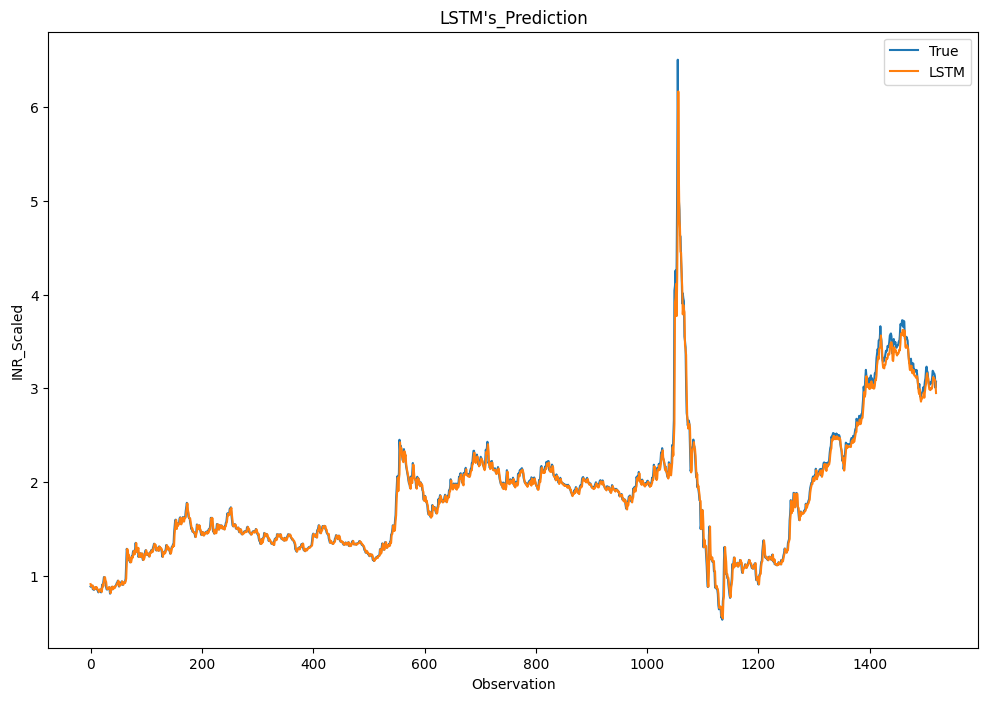

In [62]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [63]:
// import numpy as np
from tensorflow.keras.models import load_model

# Load the pre-trained GRU model
#model = load_model('lstm.h5')
#model = load_model('lstm_EUR.h5')
model = load_model('lstm_RUB.h5')

# Define input features and preprocessing
def preprocess_input(input_data):
    # Perform any necessary preprocessing here (e.g., scaling)
    # For simplicity, we'll just return the input as is
    input_data = sc.transform(input_data)
    return input_data

# Function to get user input
def get_user_input():
    # Collect input features from the user
    usd_to_money = float(input("Enter USD for exchange rate: "))

    # Add more features as needed
    return usd_to_money

# Make predictions
def predict_exchange_rate(model, input_features):
    # Reshape input features to match model input shape
    input_features = np.array(input_features).reshape(1, len(input_features))
    # Preprocess input
    preprocessed_input = preprocess_input(input_features)
    # Make prediction
    predicted_exchange_rate = model.predict(preprocessed_input)
    predicted_exchange_rate = sc.inverse_transform(predicted_exchange_rate)
    return predicted_exchange_rate

# Display results
def display_results(prediction):
    print("Predicted exchange rate:", prediction)

# Main function
def main():
    # Get user input
    usd_to_money = get_user_input()

    # Combine input features
    input_features = [usd_to_money]

    # Make predictions
    predicted_exchange_rate = predict_exchange_rate(model, input_features)

    # Display results
    display_results(predicted_exchange_rate)

if __name__ == "__main__":
    main()

SyntaxError: invalid syntax (3405772252.py, line 1)